In [65]:
MAX_LEN = 26
LR = 0.0001
BATCH_SIZE = 512

In [67]:
import os
import numpy as np
import pandas as pd
import deepdish as dd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [68]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, matthews_corrcoef, plot_confusion_matrix, auc, average_precision_score
from collections import defaultdict
import seaborn as sns

In [ ]:
def encode(seq, max_len):
    nucl_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    mat = np.zeros((4, max_len), dtype=int)
    
    for i, nucl in enumerate(seq):
        mat[nucl_dict[nucl]][i] = 1

    return mat

def encode_pair(seq1, seq2, max_len):
    enc1 = encode(seq1, max_len)
    enc2 = encode(seq2, max_len)
    return np.array([enc1, enc2])

In [69]:
class CNNRegression(pl.LightningModule):
    def __init__(self):
        super(CNNRegression, self).__init__()
        self.out_predictions = []
        
        self.conv2d_block = nn.Sequential(
            nn.Conv2d(2, 512, (4, 9)),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(0.2),
        )
        
        self.conv1d_block = nn.Sequential(
            nn.Conv1d(512, 512, 9),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Conv1d(512, 128, 3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Conv1d(128, 128, 3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, 64, 1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
        )
            
        self.lin_block = nn.Sequential(
            nn.Linear(64 * 6, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv2d_block(x)
        x = self.conv1d_block(torch.squeeze(x))
        x = x.view(x.size(0), -1)
        x = self.lin_block(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.mse_loss(torch.squeeze(self(x)), y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)
            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        val_loss = F.mse_loss(torch.squeeze(self(x)), y)
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return val_loss
            
    def test_step(self, batch, batch_idx):
        x, y = batch
        test_out = self(x)
        self.out_predictions.append(test_out)
        test_loss = F.mse_loss(torch.squeeze(test_out), y)
        self.log('test_loss', test_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return test_loss

In [70]:
train = dd.io.load('splits/train.h5')
val = dd.io.load('splits/val.h5')
test = dd.io.load('splits/test.h5')
y_train = np.load('splits/y_train.npy')
y_val = np.load('splits/y_val.npy')
y_test = np.load('splits/y_test.npy')

In [71]:
y_train = y_train * 100
y_val = y_val * 100
y_test = y_test * 100

In [72]:
X_train = [encode_pair(item[0], item[1], MAX_LEN) for item in train]
X_val = [encode_pair(item[0], item[1], MAX_LEN) for item in val]
X_test = [encode_pair(item[0], item[1], MAX_LEN) for item in test]

In [73]:
X_train = np.array(X_train, dtype=np.dtype('d'))
X_val = np.array(X_val, dtype=np.dtype('d'))
X_test = np.array(X_test, dtype=np.dtype('d'))

In [76]:
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.double)

In [77]:
train_dataloader = DataLoader(TensorDataset(torch.from_numpy(X_train).to(device=torch.device('cuda')), torch.from_numpy(y_train).to(device=torch.device('cuda'))), batch_size=NUM_BATCHES, shuffle=True, num_workers=8)
val_dataloader = DataLoader(TensorDataset(torch.from_numpy(X_val).to(device=torch.device('cuda')), torch.from_numpy(y_val).to(device=torch.device('cuda'))), batch_size=NUM_BATCHES, num_workers=8)
test_dataloader = DataLoader(TensorDataset(torch.from_numpy(X_test).to(device=torch.device('cuda')), torch.from_numpy(y_test).to(device=torch.device('cuda'))), batch_size=NUM_BATCHES, num_workers=8)

In [78]:
all_temps_df = pd.read_csv('test_set_other_temperatures.csv')
y_test_37 = all_temps_df['Yield_37C'].values
y_test_42 = all_temps_df['Yield_42C'].values
y_test_47 = all_temps_df['Yield_47C'].values
y_test_52 = all_temps_df['Yield_52C'].values
y_test_62 = all_temps_df['Yield_62C'].values

y_test_37 = y_test_37 * 100
y_test_42 = y_test_42 * 100
y_test_47 = y_test_47 * 100
y_test_52 = y_test_52 * 100
y_test_62 = y_test_62 * 100

test_dataloader_37 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_37)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_42 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_42)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_47 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_47)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_52 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_52)), batch_size=BATCH_SIZE, num_workers=0)
test_dataloader_62 = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test_62)), batch_size=BATCH_SIZE, num_workers=0)

In [79]:
loader = test_dataloader_62
labels = y_test_62

model = CNNRegression.load_from_checkpoint('...')
trainer= pl.Trainer(gpus=[0])

In [ ]:
trainer.test(model, test_dataloaders=loader)

In [ ]:
predictions = [[pred.item() for pred in preds] for preds in model.out_predictions]
preds_flat = [j for sub in predictions for j in sub]
predictions_np = np.array(preds_flat)

predictions_labels = [1 if x > 20 else 0 for x in predictions_np]
true_labels = [1 if x > 20 else 0 for x in labels]

In [57]:
cf_matrix = confusion_matrix(true_labels, predictions_labels)

<AxesSubplot:>

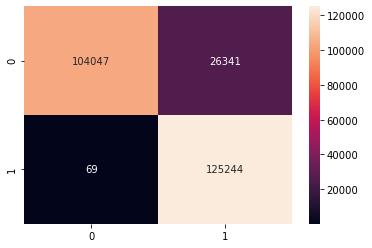

In [58]:
sns.heatmap(cf_matrix, annot=True, fmt='g')

<AxesSubplot:>

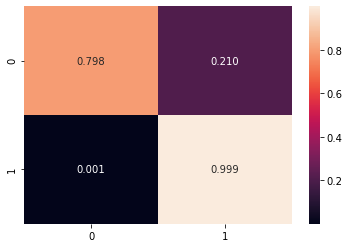

In [59]:
sns.heatmap(cf_matrix / cf_matrix.astype(np.float).sum(axis=1), annot=True, fmt='.3f')

In [60]:
matthews_corrcoef(true_labels, predictions_labels)  

0.8113760572848028

In [61]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions_labels)
auc(fpr, tpr)

0.8987146271021283

In [62]:
average_precision_score(true_labels, predictions_labels)

0.8260444150989432

In [63]:
precision_recall_fscore_support(true_labels, predictions_labels, average=None)

(array([0.99933728, 0.82622951]),
 array([0.79797988, 0.99944938]),
 array([0.88737932, 0.90462192]),
 array([130388, 125313], dtype=int64))